<h1 style="background-color:DodgerBlue;"> Anamoly detection ||  Time series ➤ LSTM-based Autoencoders </h1>


## 🚨  **Scenario: Machine Vibration Anomaly Detection (Industrial IoT) **
- Goal: Detect abnormal vibration levels that may indicate a fault or early failure in rotating machinery.

### 📦 **1. Prepare the Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Simulate time series data
time_steps = 1000
time = np.linspace(0, 50, time_steps)
vibration_normal = np.sin(time) + np.random.normal(0, 0.1, size=time_steps)
vibration_anomalous = vibration_normal.copy()
anomaly_indices = [200, 400, 600, 800]
vibration_anomalous[anomaly_indices] += np.array([2.5, -3, 2, -2.5])

df = pd.DataFrame({
    'timestamp': pd.date_range(start='2023-01-01', periods=time_steps, freq='h'),
    'vibration': vibration_anomalous
})

# Scale the data
scaler = MinMaxScaler()
df['vibration_scaled'] = scaler.fit_transform(df[['vibration']])

df.head()

,timestamp,vibration,vibration_scaled
0,2023-01-01 00:00:00,0.049671,0.541980
1,2023-01-01 01:00:00,0.036203,0.538790
2,2023-01-01 02:00:00,0.164702,0.569226
3,2023-01-01 03:00:00,0.301890,0.601720
4,2023-01-01 04:00:00,0.175450,0.571772


In [2]:
# Create LSTM sequences
def create_sequences(values, seq_length=24):
    sequences = []
    for i in range(len(values) - seq_length):
        sequences.append(values[i:i + seq_length])
    return np.array(sequences)

# Create sequences
sequence_length = 24
X_all = create_sequences(df['vibration_scaled'].values, sequence_length)

# Reshape X_all to have 3D shape: (num_samples, timesteps, features)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))  # Adding 1 feature per timestep

# Check the new shape of X_all
print("New Shape of X_all:", X_all.shape)  # Should be (num_samples, 24, 1)

# Split the data into train and test sets
train_size = int(0.6 * len(X_all))
X_train = X_all[:train_size]
X_test = X_all

New Shape of X_all: (976, 24, 1)


### 🔮 **2. Fit the LSTM Model**

In [3]:
# Ensure the input_dim is set correctly (it should be 1, as we have 1 feature per timestep)
input_dim = X_train.shape[2]  # Features per timestep (should be 1)
timesteps = X_train.shape[1]  # Length of each sequence (should be 24)

# Build the LSTM Autoencoder model
input_layer = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)
repeat = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(repeat)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.2371 - val_loss: 0.0592
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0382 - val_loss: 0.0360
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0263 - val_loss: 0.0296
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0201 - val_loss: 0.0196
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0142 - val_loss: 0.0130
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

### 🚨 **3. redict and Detect Anomalies Using Reconstruction Error**


In [4]:
# Predict & Compute Reconstruction Error
X_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_pred), axis=(1, 2))

# Threshold for anomaly
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

# Add to dataframe
df = df.iloc[sequence_length:]
df['reconstruction_error'] = reconstruction_error
df['anomaly'] = anomalies.astype(int)
df.head()

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


,timestamp,vibration,vibration_scaled,reconstruction_error,anomaly
24,2023-01-02 00:00:00,0.878035,0.738186,0.000509,0
25,2023-01-02 01:00:00,0.960471,0.757712,0.000558,0
26,2023-01-02 02:00:00,0.848806,0.731263,0.000548,0
27,2023-01-02 03:00:00,1.013588,0.770293,0.000529,0
28,2023-01-02 04:00:00,0.925623,0.749458,0.000518,0



### 📊 410. Visualize Anomalies and Export Detected Resultsion.

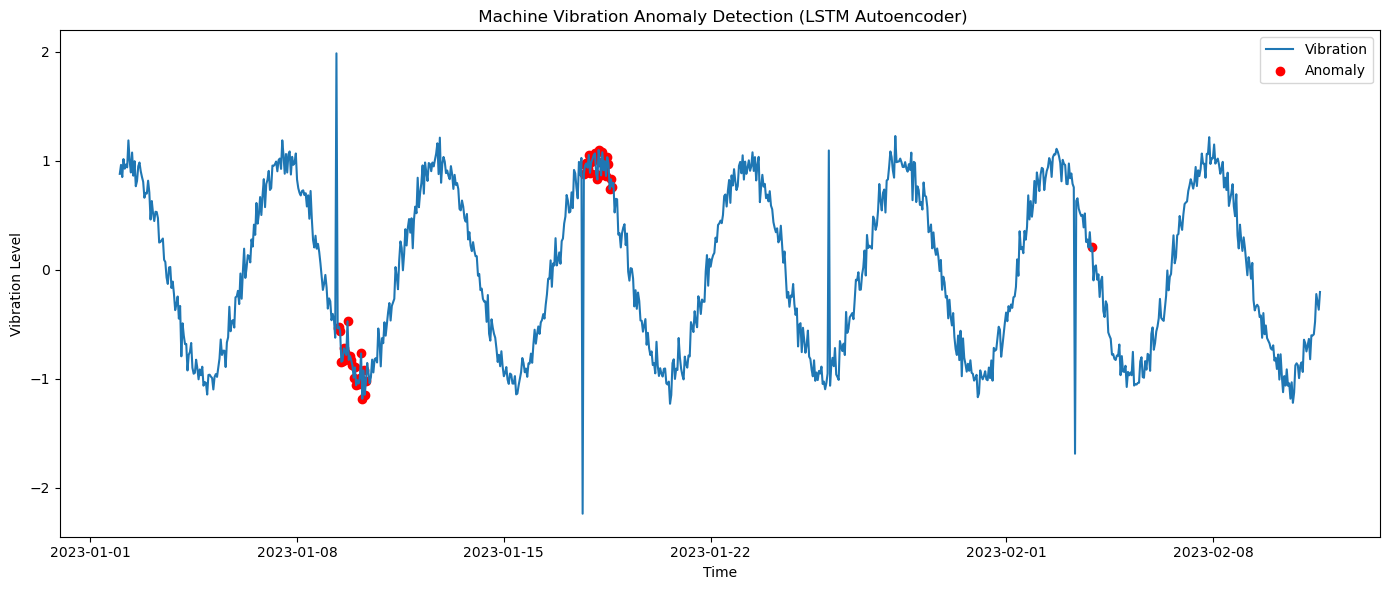

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Then continue with your plot code
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['vibration'], label='Vibration')
plt.scatter(df['timestamp'][df['anomaly'] == 1], df['vibration'][df['anomaly'] == 1], color='red', label='Anomaly')
plt.title(' Machine Vibration Anomaly Detection (LSTM Autoencoder)')
plt.xlabel('Time')
plt.ylabel('Vibration Level')
plt.legend()
plt.tight_layout()
plt.show()
